In [1]:
import json
import os
from pathlib import Path

from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

from data import constants
from data.eluc_data import ELUCData
from prescriptors.esp.unileaf_prescriptor import UnileafPrescriptor, reco_to_context_actions
from predictors.neural_network.neural_net_predictor import NeuralNetPredictor

In [2]:
dataset = ELUCData()

### Load Results

In [25]:
experiment_results_dir = Path("prescriptors/trained_prescriptors/LocTimeCropNoSoft/first_try")
stats_file = experiment_results_dir / "experiment_stats.csv"
with open(stats_file) as csv_file:
    stats_df = pd.read_csv(csv_file, sep=',')
last_gen_filename = os.path.join(experiment_results_dir, str(len(stats_df)) + '.csv')
last_gen_df = pd.read_csv(last_gen_filename)
pareto_df = last_gen_df[last_gen_df['NSGA-II_rank'] == 1]
# Sort by first objective, maximize: lowest to highest, minimize: highest to lowest
pareto_df = pareto_df.sort_values(by='change', ascending=True)

## Generation Plotting

In [26]:
def get_pareto_df(dir, gen):
    """
    Gets the pareto df for a given generation.
    :param dir: The experiment results directory.
    :param gen: The generation to get the pareto df for.
    """
    gen_filename = os.path.join(dir, f"{gen}.csv")
    gen_df = pd.read_csv(gen_filename)
    gen_pareto_df = gen_df[gen_df['NSGA-II_rank'] == 1]
    # Sort by first objective, maximize: lowest to highest, minimize: highest to lowest
    gen_pareto_df = gen_pareto_df.sort_values(by='change', ascending=True)
    gen_pareto_df["Name"] = f"Gen {gen}"
    return gen_pareto_df

def get_merged_df(dir, gens):
    """
    Gets the pareto df for multiple generations and merges them into one.
    :param dir: The experiment results directory.
    :param gens: List of generations to get the pareto df for.
    """
    dfs = []
    for gen in gens:
        dfs.append(get_pareto_df(dir, gen))
    merged_df = pd.concat(dfs, ignore_index=True)
    return merged_df

def get_overall_pareto_df(final_gen):
    pareto_list = []
    # First, go through each gen and add prescriptors that aren't already dominated.
    for gen in range(1, final_gen + 1):
        gen_filename = os.path.join(experiment_results_dir, f"{gen}.csv")        
        gen_df = pd.read_csv(gen_filename)
        gen_pareto_df = gen_df[gen_df['NSGA-II_rank'] == 1]
        for idx, row in gen_pareto_df.iterrows():
            pareto = True
            for p in pareto_list:
                # if (((p['ELUC'] < row['ELUC']) and (p['change'] <= row['change'])) or \
                #     ((p['ELUC'] <= row['ELUC']) and (p['change'] < row['change'])) or \
                #     ((p['ELUC'] == row['ELUC']) and (p['change'] == row['change']))):
                if p['ELUC'] <= row['ELUC'] and p['change'] <= row['change']:
                    pareto = False
                    break
            if pareto:
                pareto_list.append(row)

    # Go through the results and remove prescriptors that got dominated by later ones.
    filtered_pareto_list = []
    for i in range(len(pareto_list)):
        row = pareto_list[i]
        pareto = True
        for j in range(i+1, len(pareto_list)):
            p = pareto_list[j]
            # if (((p['ELUC'] < row['ELUC']) and (p['change'] <= row['change'])) or \
            #     ((p['ELUC'] <= row['ELUC']) and (p['change'] < row['change'])) or \
            #     ((p['ELUC'] == row['ELUC']) and (p['change'] == row['change']))):
            if p['ELUC'] <= row['ELUC'] and p['change'] <= row['change']:
                pareto = False
                break
        if pareto:
            filtered_pareto_list.append(row)

    return pd.DataFrame(filtered_pareto_list)


def plot_gens(dir, gens, save=False):
    """
    Plots the pareto front for multiple generations.
    :param dir: The experiment results directory.
    :param gens: List of generations to plot the pareto front for.
    """
    merged_df = get_merged_df(dir, gens)
    fig, ax = plt.subplots()
    cmap = plt.get_cmap("tab10")
    colors = [cmap(i) for i in [0, 1, 2, 5, 4]]
    curve_names = []
    for i, gen in enumerate(gens):
        curve_name = f"Gen {gen}"
        curve_names.append(curve_name)

        merged_df[merged_df["Name"] == curve_name].plot(x='change',
                       y='ELUC',
                       marker='o',
                       ylabel='ELUC',
                       ax=ax,
                       color=colors[i],
                       label="Gen " + str(gen))

    overall_pareto_df = get_overall_pareto_df(gens[-1])
    overall_pareto_df = overall_pareto_df.sort_values(by="change")
    overall_pareto_df.plot(x='change', y='ELUC', c='r', marker='o', ax=ax, label="Final Pareto Front")
    #plt.xlim(0, 0.4)
    plt.grid() 
    # handles, labels = plt.gca().get_legend_handles_labels()
    # order = [0, 1, 2, 4, 3]
    # plt.legend([handles[idx] for idx in order], [curve_names[idx] for idx in order], loc="upper right")
    plt.legend(prop={'size': 9})
    #plt.title("Pareto Fronts Across Generations")
    if save:
        plt.savefig("figures/pareto.png", format="png", dpi=300)
    plt.show()

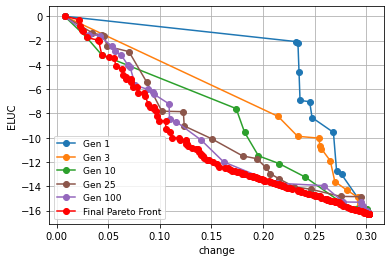

In [27]:
plot_gens(experiment_results_dir, [1, 3, 10, 25, 100], save=False)

In [28]:
def get_gen_df(gen):
    gen_filename = os.path.join(experiment_results_dir, f"{gen}.csv")
    gen_df = pd.read_csv(gen_filename)
    # Sort by first objective, maximize: lowest to highest, minimize: highest to lowest
    gen_df = gen_df.sort_values(by='change', ascending=True)
    gen_df["Name"] = f"Gen {gen}"
    return gen_df

def get_all_gens_df(gens):
    dfs = []
    for gen in gens:
        dfs.append(get_gen_df(gen))
    merged_df = pd.concat(dfs, ignore_index=True)
    return merged_df

In [29]:
def plot_all_gens(dir, gens, save=False):
    all_gens_df = get_all_gens_df(gens)
    fig, ax = plt.subplots()

    all_gens_df.plot.scatter(x='change',
                             y='ELUC',
                             ax=ax,
                             label="All prescriptors evaluated")
    # Plot last gen's pareto front in red
    
    #get_pareto_df(dir, gens[-1]).plot.scatter(x='change', y='ELUC', c='red', ax=ax, label="Gen 100 Pareto Front")
    overall_pareto = get_overall_pareto_df(gens[-1])
    overall_pareto.plot.scatter(x='change', y='ELUC', c='red', ax=ax, label="Final Pareto Front")
    plt.grid()
    #plt.title("All Generations All Prescriptor Performance")
    plt.legend(loc="upper left")
    if save:
        plt.savefig("figures/allgens.png", format="png", dpi=300) 
    plt.show()

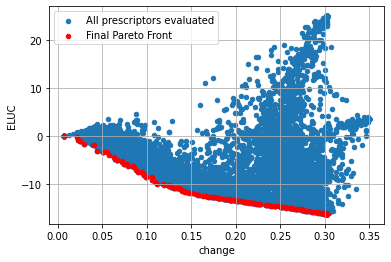

In [30]:
plot_all_gens(experiment_results_dir, [a + 1 for a in range(100)], save=False)

In [31]:
all_gen_pareto_df = get_overall_pareto_df(len(stats_df))

## Heuristic Pareto

In [32]:
def perfect_prescribe_row(row, reco_coefs, pct_change):
    # Weird case where row is all zeroes
    if row[constants.LAND_USE_COLS].sum() == 0:
        return row
    scaled_change = pct_change * row[constants.LAND_USE_COLS].sum()
    best_col = reco_coefs[-1][0]
    max_change = min(row[constants.RECO_COLS].sum() - row[best_col], scaled_change)
    changed = 0
    for coef in reco_coefs:
        if not coef[0] == best_col: # This technically shouldn't be necessary
            # If we have more change left than there is in this column, delete it all
            if row[coef[0]] < max_change - changed:
                changed += row[coef[0]]
                row[coef[0]] = 0
            # Otherwise, remove however much change is left
            else:
                row[coef[0]] -= (max_change - changed)
                changed = max_change
                break
    row[best_col] += changed
    return row


def even_prescribe_row(row, pct_change, best_col):
    # Weird case where row is all zeroes
    if row[constants.LAND_USE_COLS].sum() == 0:
        return row
    scaled_change = pct_change * row[constants.LAND_USE_COLS].sum()
    presc_cols = [col for col in constants.RECO_COLS]
    presc_cols.remove(best_col)
    row_sum = row[presc_cols].sum()
    max_change = min(row_sum, scaled_change)
    row[presc_cols] = row[presc_cols].apply(lambda col: col - (col/row_sum) * max_change if col - (col/row_sum) * max_change >= 0 else 0)
    row[best_col] = row[best_col] + max_change
    return row

In [33]:
def perfect_prescribe(context, pct_change, coefs):
    """
    Perfect prescription algorithm:
        1. Add to forest as much pct change as possible up to forest = 1
        2. Subtract from bottom up however much was changed
    """

    adjusted = context.copy()
    coefficients = zip(constants.LAND_USE_COLS, coefs)
    reco_coefs = [coef for coef in coefficients if coef[0] in constants.RECO_COLS]
    reco_coefs = sorted(reco_coefs, key=lambda x: x[1], reverse=True)
    adjusted = adjusted.apply(lambda row: perfect_prescribe_row(row, reco_coefs, pct_change), axis=1)
    return adjusted


def even_prescribe(context, pct_change, best_col):
    """
    Takes evenly from all columns and adds to best col
    """
    adjusted = context.copy()
    adjusted = adjusted.apply(lambda row: even_prescribe_row(row, pct_change, best_col), axis=1)
    return adjusted


def heuristic_prescribe_and_predict(context_df, dummy_prescriptor, presc_func, *presc_args):
    """
    Given a context and a heuristic function, prescribe actions and predict the resulting ELUC.
    :param context_df: The context dataframe.
    :param dummy_prescriptor: A dummy prescriptor to perform standard ELUC prediction.
    :param presc_func: The heuristic function to prescribe actions.
    :param presc_args: The arguments to pass to the heuristic function.
    """
    reco_df = presc_func(context_df, *presc_args)
    prescribed_actions_df = reco_df[constants.RECO_COLS] - context_df[constants.RECO_COLS]

    # Rename the columns to match what the predictor expects
    prescribed_actions_df = prescribed_actions_df.rename(constants.RECO_MAP, axis=1)
    prescribed_actions_df[constants.NO_CHANGE_COLS] = 0
    
    # Aggregate the context and actions dataframes.
    context_actions_df = pd.concat([context_df, prescribed_actions_df[constants.DIFF_LAND_USE_COLS]], axis=1)
    
    # Reorder
    prescribed_actions_df = context_actions_df[constants.DIFF_LAND_USE_COLS]

    eluc = dummy_prescriptor.predict_eluc(context_actions_df).values
    change = (prescribed_actions_df[prescribed_actions_df > 0].sum(axis=1) / context_actions_df[constants.LAND_USE_COLS].sum(axis=1))
    
    context_actions_df["ELUC"] = eluc
    context_actions_df["change"] = change
    return context_actions_df

In [34]:
nnp = NeuralNetPredictor()
nnp.load("predictors/neural_network/trained_models/experiment_nn")
presc_config = None
with open("prescriptors/unileaf_configs/config-loctime-crop-nosoft.json") as f:
    presc_config = json.load(f)
dummy_prescriptor = UnileafPrescriptor(presc_config,
                                   dataset.train_df.iloc[:1],
                                   dataset.encoder,
                                   [nnp])

test_df = dataset.test_df.sample(frac=0.01, random_state=100)
encoded_test_df = dataset.encoder.encode_as_df(test_df)
context_df = test_df[constants.CAO_MAPPING["context"]]
encoded_context_df = encoded_test_df[constants.CAO_MAPPING["context"]]

### Even Prescriptors

In [19]:
#pcts = [i / len(all_gen_pareto_df["id"].unique()) for i in range(1, len(all_gen_pareto_df["id"].unique()) + 1)]
n_points = 100
pcts = [i / n_points for i in range(1, n_points + 1)]

even_elucs = []
even_changes = []
best_col = "secdf"
for pct in tqdm(pcts):
    result_df = heuristic_prescribe_and_predict(context_df, dummy_prescriptor, even_prescribe, pct, best_col)
    even_elucs.append(result_df["ELUC"].mean())
    even_changes.append(result_df["change"].mean())

print(even_elucs)
print(even_changes)

100%|██████████| 100/100 [00:13<00:00,  7.19it/s]

[-0.5754785405085634, -1.1629679891656535, -1.793822559218494, -2.4516994703682773, -3.105940924224507, -3.7501483025659, -4.387583638570504, -4.991657963644354, -5.553082921402, -6.086145609053677, -6.599633311797251, -7.097094000176929, -7.581765419494001, -8.042519814025251, -8.47580833270331, -8.905256301955722, -9.333149937857259, -9.760031065594045, -10.179807265487563, -10.59719360224765, -11.01342558668958, -11.429018446781397, -11.837722101785898, -12.244751803690717, -12.644991274020867, -13.032089312759291, -13.413455251379425, -13.794306092078015, -14.171453809987394, -14.544340559818506, -14.917146098321114, -15.2881537033536, -15.659281785628991, -16.03051956483449, -16.39920058925583, -16.760219669591276, -17.106644276304657, -17.446759918310406, -17.783740261175396, -18.117556477925973, -18.45127912080286, -18.785242403886514, -19.119239694129316, -19.447155731081942, -19.774268056295114, -20.10105353943866, -20.427639233231524, -20.754366336334815, -21.080333740310213,

### "Perfect" Prescriptors

In [35]:
linreg = LinearRegression()
linreg.fit(dataset.train_df[constants.DIFF_LAND_USE_COLS], dataset.train_df["ELUC"])
print(linreg.coef_)

[110.70173   59.01831  -56.613754  22.683641  28.28591  -17.186794
  27.15772   70.575554]


In [21]:
coefs = linreg.coef_

perfect_elucs = []
perfect_changes = []
for pct in tqdm(pcts):
    result_df = heuristic_prescribe_and_predict(context_df, dummy_prescriptor, perfect_prescribe, pct, coefs)
    perfect_elucs.append(result_df["ELUC"].mean())
    perfect_changes.append(result_df["change"].mean())

print(perfect_elucs)
print(perfect_changes)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:09<00:00, 10.38it/s]

[-0.7586607991754797, -1.5178547749925533, -2.262521200334463, -3.0134459545449563, -3.7445319512811364, -4.4562845942432014, -5.1626431550274985, -5.845756159023784, -6.508922826951179, -7.156761950503675, -7.795672624739712, -8.41279513264784, -9.015447790763574, -9.593486544197235, -10.145300935051637, -10.686024241263196, -11.22327972079405, -11.754197094364578, -12.274519563512348, -12.792975475278746, -13.30659249774974, -13.812026891632492, -14.30644691882348, -14.79616444298352, -15.276860755389366, -15.742704419363607, -16.197280600103444, -16.64356077609277, -17.07644073337856, -17.494737587982936, -17.905588402780598, -18.310292166178854, -18.710175198023947, -19.10657050471954, -19.49731305320694, -19.879545640652807, -20.24927551988036, -20.611895375067515, -20.971672722675564, -21.32843560330432, -21.67979219634964, -22.023975793047363, -22.364769391829295, -22.697782140677603, -23.023380933273902, -23.341342365990965, -23.65517079638349, -23.96459359822488, -24.265990607

### Trained Prescriptors

In [22]:
from keras.models import load_model

def load_prescriptor(id, verbose=False):
    gen = int(id.split('_')[0])
    prescriptor_model_filename = os.path.join(experiment_results_dir,
                                          str(gen),
                                          id + '.h5')
    if verbose:
        print(f'Loading prescriptor model: {prescriptor_model_filename}')
    prescriptor_model = load_model(prescriptor_model_filename, compile=False)
    return prescriptor_model

In [23]:
def trained_prescribe_and_predict(encoded_context, id, encoder, dummy_prescriptor):
    prescriptor = load_prescriptor(id)
    reco_land_use = dummy_prescriptor.prescribe(prescriptor, encoded_context)
    reco_df = pd.DataFrame(reco_land_use["reco_land_use"].tolist(), columns=constants.RECO_COLS)
    context_actions_df = reco_to_context_actions(reco_df, encoded_context, encoder)
    prescribed_actions_df = context_actions_df[constants.DIFF_LAND_USE_COLS]
    eluc = dummy_prescriptor.predict_eluc(context_actions_df)
    change = (prescribed_actions_df[prescribed_actions_df > 0].sum(axis=1) / context_actions_df[constants.LAND_USE_COLS].sum(axis=1))

    context_actions_df["ELUC"] = eluc.values
    context_actions_df["change"] = change.values

    return context_actions_df

trained_elucs = []
trained_changes = []
print(len(all_gen_pareto_df))
for id in all_gen_pareto_df["id"].unique():
    result_df = trained_prescribe_and_predict(encoded_context_df, id, dataset.encoder, dummy_prescriptor)
    trained_elucs.append(result_df["ELUC"].mean())
    trained_changes.append(result_df["change"].mean())

179
Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

6/6 [==============================] - 0s 14ms/step


KeyboardInterrupt: 

[-0.48221816699758446, -0.9394669421294041, -1.3743253790420253, -1.8001423494717983, -2.219820666832692, -2.635428801315339, -3.046544256552684, -3.4453552896636666, -3.82791888512053, -4.196727289448885, -4.55433987895778, -4.902874757589118, -5.243942582762411, -5.578078914458431, -5.906627517283578, -6.2302686359310675, -6.550814176207898, -6.868715558159256, -7.183615656936949, -7.4963909966997315, -7.807610002559771, -8.117324481332808, -8.426058085525238, -8.7335642521454, -9.039738755231769, -9.343899411829538, -9.64522472187804, -9.944320966657152, -10.241306116076517, -10.536105109432059, -10.828803332643037, -11.119465025419073, -11.407833084806235, -11.694504659960593, -11.979461674864682, -12.262013770975342, -12.542404426319623, -12.820567301295045, -13.096352615726905, -13.369904867955116, -13.64132677345688, -13.910494931220928, -14.177422679716337, -14.441737382444007, -14.703954113069376, -14.964176562482285, -15.222181254368392, -15.477992034299701, -15.7317583015287

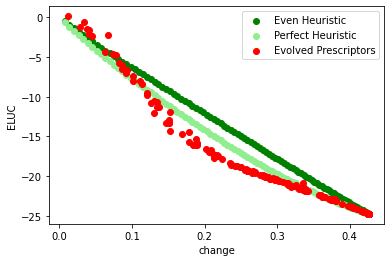

In [ ]:
print(even_elucs)
print(even_changes)
print(perfect_elucs)
print(perfect_changes)
print(trained_elucs)
print(trained_changes)
print(dict(zip(constants.DIFF_LAND_USE_COLS, coefs)))
plt.scatter(even_changes, even_elucs, color="green", label="Even Heuristic")
plt.scatter(perfect_changes, perfect_elucs, color="lightgreen", label="Perfect Heuristic")
plt.scatter(trained_changes, trained_elucs, color="red", label="Evolved Prescriptors")
plt.legend()
plt.xlabel("change")
plt.ylabel("ELUC")
#plt.savefig("figures/heuristics.png", format="png", dpi=300)
plt.show()

In [ ]:
def filter_dominating(changes, elucs):
    """
    Gets indices of points that are not dominated by any other point.
    """
    non_dominated_idxs = []
    for i in range(len(changes)):
        dominated = False
        for j in range(len(changes)):
            if i != j and changes[i] >= changes[j] and elucs[i] >= elucs[j]:
                dominated = True
                break
        if not dominated:
            non_dominated_idxs.append(i)
    return non_dominated_idxs


def two_dim_decreasing_neg_hypervolume(x, y, right=1):
    """
    Computes the hypervolume of a 2d pareto.
    We use the sklearn AUC function to find the area between our curve and y = 0,
    then we add the area of the rectangle to the right of the pareto.
    This assumes the y coordinate of the reference point is 0 (which it is in our ELUC case).
    We only consider points under y = 0, adding point 0,0 to the pareto if it is not there.
    :param x: List of x coordinates between [0, 1]
    :param y: List of y coordinates
    :param right: the rightmost edge to compute the rectangle to. Defaults to 1.
    """

    assert len(x) == len(y)
    assert all([0 <= x_i <= 1 for x_i in x])
    assert right >= max(x)

    # Filter out positive y values
    neg_idxs = [i for i in range(len(y)) if y[i] < 0]
    x = [x[i] for i in neg_idxs]
    y = [y[i] for i in neg_idxs]

    # Sort the pareto by x
    sorted_x = sorted(x)
    sorted_y = [y[x.index(sorted_x[i])] for i in range(len(x))]

    # Add point 0,0 if it is not there
    if sorted_x[0] != 0:
        sorted_x = [0] + sorted_x
        sorted_y = [0] + sorted_y

    # Add bottom right point if it is not there
    if sorted_x[-1] != right:
        sorted_x.append(right)
        sorted_y.append(sorted_y[-1])

    # Take the rectangle that is to the top right of each point.
    area = 0
    for i in range(len(sorted_x) - 2, -1, -1):
        area += (sorted_x[i] - sorted_x[i + 1]) * sorted_y[i]

    return area

19.57749551115567
20.176138133868754
20.447397969763387


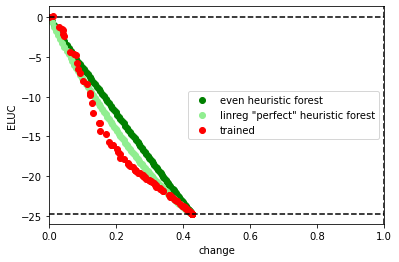

In [ ]:
# Filter out points that are dominated by others
idxs = filter_dominating(trained_changes, trained_elucs)
trained_changes_filtered = [trained_changes[i] for i in idxs]
trained_elucs_filtered = [trained_elucs[i] for i in idxs]

print(two_dim_decreasing_neg_hypervolume(even_changes, even_elucs))
print(two_dim_decreasing_neg_hypervolume(perfect_changes, perfect_elucs))
print(two_dim_decreasing_neg_hypervolume(trained_changes_filtered, trained_elucs_filtered))

trained_changes_sorted = sorted(trained_changes_filtered)
trained_elucs_sorted = [trained_elucs_filtered[trained_changes_filtered.index(change)] for change in trained_changes_sorted]

plt.scatter([0] + even_changes, [0] + even_elucs, color="green", label="even heuristic forest")
plt.scatter([0] + perfect_changes, [0] + perfect_elucs, color="lightgreen", label="linreg \"perfect\" heuristic forest")
plt.scatter([0] + trained_changes_sorted, [0] + trained_elucs_sorted, color="red", label="trained")
plt.legend()
plt.xlabel("change")
plt.ylabel("ELUC")
plt.xlim([0, 1])

plt.axhline(0, color="black", linestyle="--")
plt.axhline(min([min(even_elucs), min(perfect_elucs), min(trained_elucs)]), color="black", linestyle="--")
plt.axvline(1, color="black", linestyle="--")
plt.show()

## Examine Results

34 0.19793502238705463 -11.979461674864682
34 0.19793502238705463 -14.05574760275695
25 0.1894858919523161 -16.040059821432553


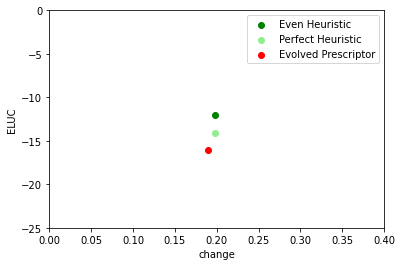

In [42]:
def get_idx_close(change, changes):
    diff = [abs(c - change) for c in changes]
    idx = diff.index(min(diff))
    return idx

pct = 0.2
trained_idx = get_idx_close(pct, trained_changes_sorted) - 1
even_idx = get_idx_close(pct, even_changes)
perfect_idx = get_idx_close(pct, perfect_changes)

print(even_idx, even_changes[even_idx], even_elucs[even_idx])
print(perfect_idx, perfect_changes[perfect_idx], perfect_elucs[perfect_idx])
print(trained_idx, trained_changes_sorted[trained_idx], trained_elucs_sorted[trained_idx])

plt.scatter([even_changes[even_idx]], [even_elucs[even_idx]], color="green", label="Even Heuristic")
plt.scatter([perfect_changes[perfect_idx]], [perfect_elucs[perfect_idx]], color="lightgreen", label="Perfect Heuristic")
plt.scatter([trained_changes_sorted[trained_idx]], [trained_elucs_sorted[trained_idx]], color="red", label="Evolved Prescriptor")
plt.legend()
plt.xlabel("change")
plt.ylabel("ELUC")
plt.xlim([0, 0.4])
plt.ylim([-25, 0])
#plt.title("Average Change vs. ELUC for ~20% change prescriptors")
#plt.savefig("figures/prescmeans.png", format="png", dpi=300)
plt.show()

In [43]:
trained_idx_unsort = trained_changes.index(trained_changes_sorted[trained_idx])
trained_result = trained_prescribe_and_predict(encoded_context_df, all_gen_pareto_df["id"].unique()[trained_idx_unsort], dataset.encoder, dummy_prescriptor)
even_result = heuristic_prescribe_and_predict(context_df, dummy_prescriptor, even_prescribe, pcts[even_idx], best_col)
perfect_result = heuristic_prescribe_and_predict(context_df, dummy_prescriptor, perfect_prescribe, pcts[perfect_idx], coefs)

trained_result = trained_result.set_index(even_result.index)

832/832 [==============================] - 3s 4ms/step


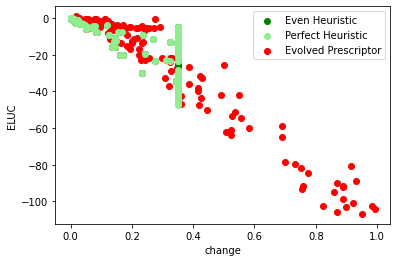

In [44]:
trained_sample = trained_result.sample(frac=0.01, random_state=42)
even_sample = even_result.loc[trained_sample.index]
perfect_sample = perfect_result.loc[trained_sample.index]

plt.scatter(trained_sample["change"], trained_sample["ELUC"], color="red", label="Evolved Prescriptor")
plt.scatter(even_sample["change"], even_sample["ELUC"], color="green", label="Even Heuristic")
plt.scatter(perfect_sample["change"], perfect_sample["ELUC"], color="lightgreen", label="Perfect Heuristic")
# Rearrange legend (from stackoverflow)
handles, labels = plt.gca().get_legend_handles_labels()
order = [1, 2, 0]
plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order])
plt.xlabel("change")
plt.ylabel("ELUC")
#plt.title("Expanded view of ~20% change prescriptors (subsampled)")
#plt.savefig("figures/prescexpanded.png", format="png", dpi=300)
plt.show()

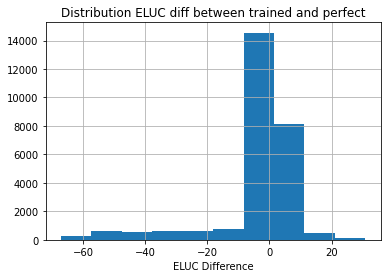

In [45]:
eluc_diff = trained_result["ELUC"] - perfect_result["ELUC"]
plt.title("Distribution ELUC diff between trained and perfect")
plt.xlabel("ELUC Difference")
plt.hist(eluc_diff)
plt.grid()
plt.show()

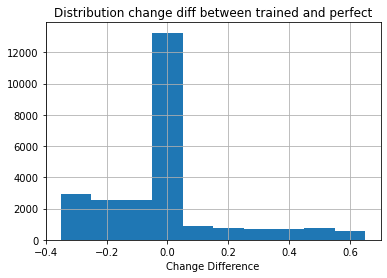

In [46]:
change_diff = trained_result["change"] - perfect_result["change"]
plt.title("Distribution change diff between trained and perfect")
plt.xlabel("Change Difference")
plt.hist(change_diff)
plt.grid()
plt.show()

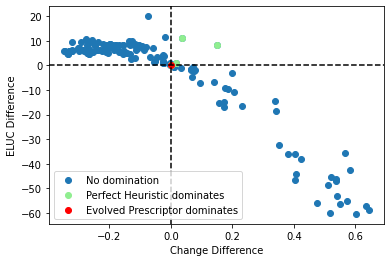

In [48]:
diff_df = pd.DataFrame()
diff_df["change"] = trained_sample["change"] - perfect_sample["change"]
diff_df["ELUC"] = trained_sample["ELUC"] - perfect_sample["ELUC"]
dom = diff_df[(diff_df["change"] < 0) & (diff_df["ELUC"] < 0)]
other_dom = diff_df[(diff_df["change"] > 0) & (diff_df["ELUC"] > 0)]
plt.scatter(diff_df["change"], diff_df["ELUC"], label="No domination")
plt.scatter(other_dom["change"], other_dom["ELUC"], color="lightgreen", label="Perfect Heuristic dominates")
plt.scatter(dom["change"], dom["ELUC"], color="red", label="Evolved Prescriptor dominates")
plt.axhline(0, color="black", linestyle="--")
plt.axvline(0, color="black", linestyle="--")
plt.xlabel("Change Difference")
plt.ylabel("ELUC Difference")
#plt.title("Change Diff vs. ELUC Diff Between Trained and Perfect (subsampled)")
plt.legend()
#plt.savefig("figures/prescdiffs.png", format="png", dpi=300)
plt.show()

In [49]:
low_change_idx = change_diff[(change_diff < 0)].index
low_change_eluc_diff = eluc_diff[low_change_idx]
low_change_neg_eluc_diff = low_change_eluc_diff[low_change_eluc_diff < 0]
print(f"Number less change better ELUC: {len(low_change_neg_eluc_diff)}")
min_idx = low_change_neg_eluc_diff.sort_values().index[0]
print(f"Max difference in ELUC with less change: {eluc_diff[min_idx]}")

print("Changes")
print(even_result.loc[min_idx]["change"], perfect_result.loc[min_idx]["change"], trained_result.loc[min_idx]["change"])
print()
print("ELUCs")
print(even_result.loc[min_idx]["ELUC"], perfect_result.loc[min_idx]["ELUC"], trained_result.loc[min_idx]["ELUC"])
print()
print([f"{col}: {even_result.loc[min_idx][col]}" for col in constants.CAO_MAPPING["context"]])
print("Prescribed:")
print([f"{col}: {even_result.loc[min_idx][col]}" for col in constants.DIFF_RECO_COLS])
print([f"{col}: {perfect_result.loc[min_idx][col]}" for col in constants.DIFF_RECO_COLS])
print([f"{col}: {trained_result.loc[min_idx][col]}" for col in constants.DIFF_RECO_COLS])


Number less change better ELUC: 47
Max difference in ELUC with less change: time  lat     lon   
2016  42.875  45.875   -0.20701
Name: ELUC, dtype: float64
Changes
time  lat     lon   
2016  42.875  45.875    0.35
Name: change, dtype: float64 time  lat     lon   
2016  42.875  45.875    0.35
Name: change, dtype: float64 time  lat     lon   
2016  42.875  45.875    0.342483
Name: change, dtype: float64

ELUCs
time  lat     lon   
2016  42.875  45.875   -21.525127
Name: ELUC, dtype: float64 time  lat     lon   
2016  42.875  45.875   -26.671085
Name: ELUC, dtype: float64 time  lat     lon   
2016  42.875  45.875   -26.878096
Name: ELUC, dtype: float64

['crop: time  lat     lon   \n2016  42.875  45.875    0.171379\nName: crop, dtype: float32', 'pastr: time  lat     lon   \n2016  42.875  45.875    0.007045\nName: pastr, dtype: float32', 'primf: time  lat     lon   \n2016  42.875  45.875    0.0\nName: primf, dtype: float32', 'primn: time  lat     lon   \n2016  42.875  45.875    0.515484\nN

/var/folders/4c/sd5grc691sx_dp1xqn1s9dyc0000gq/T/ipykernel_43643/3349738372.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  print(f"Max difference in ELUC with less change: {eluc_diff[min_idx]}")
/var/folders/4c/sd5grc691sx_dp1xqn1s9dyc0000gq/T/ipykernel_43643/3349738372.py:9: PerformanceWarning: indexing past lexsort depth may impact performance.
  print(even_result.loc[min_idx]["change"], perfect_result.loc[min_idx]["change"], trained_result.loc[min_idx]["change"])
/var/folders/4c/sd5grc691sx_dp1xqn1s9dyc0000gq/T/ipykernel_43643/3349738372.py:12: PerformanceWarning: indexing past lexsort depth may impact performance.
  print(even_result.loc[min_idx]["ELUC"], perfect_result.loc[min_idx]["ELUC"], trained_result.loc[min_idx]["ELUC"])
/var/folders/4c/sd5grc691sx_dp1xqn1s9dyc0000gq/T/ipykernel_43643/3349738372.py:14: PerformanceWarning: indexing past lexsort depth may impact performance.
  print([f"{col}: {even_result.loc[min_idx][col]}" for col in constant

In [50]:
# How many are greater than the MAE of predictor model
signif = low_change_neg_eluc_diff[abs(low_change_neg_eluc_diff) > 0.05]
print(f"Number of points where trained prescriptor prescribes less change than perfect heuristic AND produces better ELUC by more than predictor model MAE: {len(signif)}")
print(f"Average difference in change for these points: {change_diff.loc[signif.index].mean()}")
print(f"Average difference in ELUC for these points: {signif.mean()}")

Number of points where trained prescriptor prescribes less change than perfect heuristic AND produces better ELUC by more than predictor model MAE: 4
Average difference in change for these points: -0.007977895921654751
Average difference in ELUC for these points: -0.14235717058181763


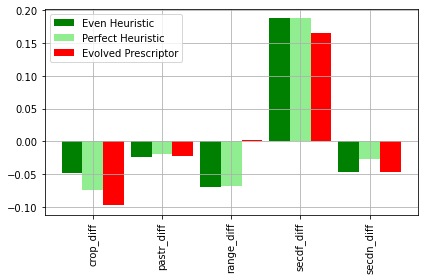

In [52]:
even_total_diffs = even_result[constants.DIFF_RECO_COLS].sum(axis=0) / len(even_result)
perfect_total_diffs = perfect_result[constants.DIFF_RECO_COLS].sum(axis=0) / len(perfect_result)
trained_total_diffs = trained_result[constants.DIFF_RECO_COLS].sum(axis=0) / len(trained_result)

xticks = np.arange(len(constants.DIFF_RECO_COLS))

plt.bar(xticks-0.3, even_total_diffs, 0.3, label="Even Heuristic", color="green")
plt.bar(xticks, perfect_total_diffs, 0.3, label="Perfect Heuristic", color="lightgreen")
plt.bar(xticks+0.3, trained_total_diffs, 0.3, label="Evolved Prescriptor", color="red")
plt.xticks(xticks, constants.DIFF_RECO_COLS, rotation=90)
plt.legend()
plt.grid()
#plt.title("Average land use change for each prescriptor")
fig = plt.gcf()
fig.set_tight_layout(True)
#plt.savefig("figures/prescbar.png", format="png", dpi=300)
plt.show()

#### See what features cause more change

[0.9330519770471174, 0.3597655415302683, -0.30921000776144275, -0.2718086416064531, -0.09501254090287084, -0.11921383231465675, 0.2264343213066571, 0.14329173717985333, 0.31016870759090026, -0.25688973673661797, -0.25944979642860755, 0.005204622358066269]


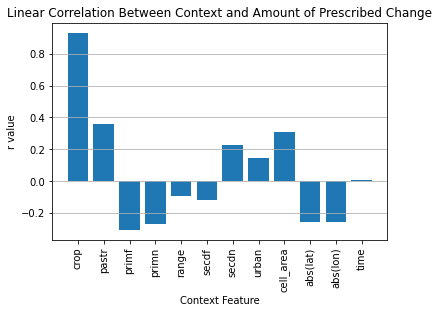

In [53]:
rs = []
for col in constants.LAND_USE_COLS + constants.NONLAND_FEATURES:
    feat = trained_result[col]
    if col == "lat" or col == "lon":
        feat = abs(feat)
    rs.append(feat.corr(trained_result["change"]))
print(rs)

labels = constants.LAND_USE_COLS + constants.NONLAND_FEATURES
labels[labels.index("lat")] = "abs(lat)"
labels[labels.index("lon")] = "abs(lon)"
plt.bar(labels, rs)
plt.xticks(rotation=90)
plt.xlabel("Context Feature")
plt.ylabel("r value")
plt.title("Linear Correlation Between Context and Amount of Prescribed Change")
plt.grid(axis="y")
#plt.savefig("figures/corr.png", format="png", dpi=300)
plt.show()

In [54]:
def plot_context_change(feature, save):
    plt.scatter(trained_sample[feature], trained_sample["change"])
    plt.title(f"Context {feature} vs. Amount of Prescribed Change")
    plt.ylabel("Change")
    plt.xlabel(feature)
    if feature in constants.LAND_USE_COLS:
        plt.plot([0, 1], [0, 1], color="black", linestyle="--", label="y=x")
        plt.plot([0, 1], [1, 0], color="red", linestyle="--", label="y=1-x")
        plt.legend()
    if save:
        plt.savefig(f"figures/{feature}change.png", format="png", dpi=300)
    plt.show()

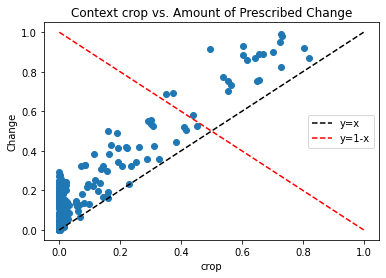

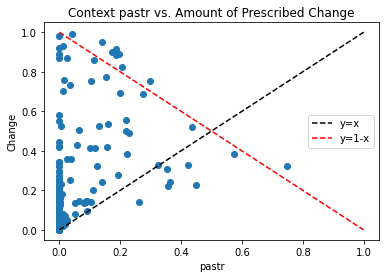

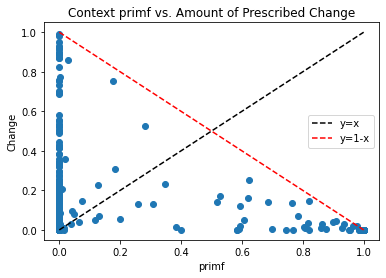

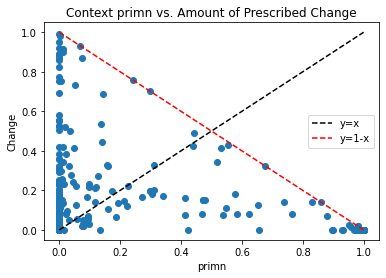

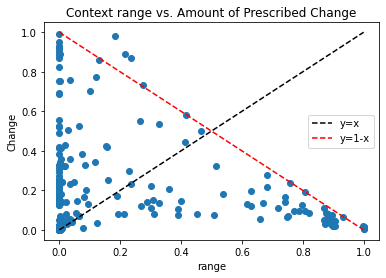

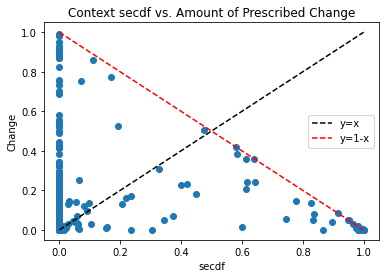

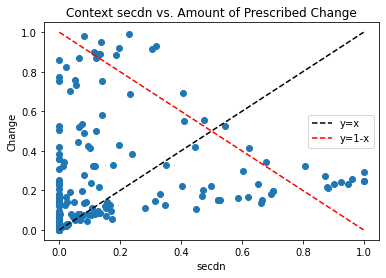

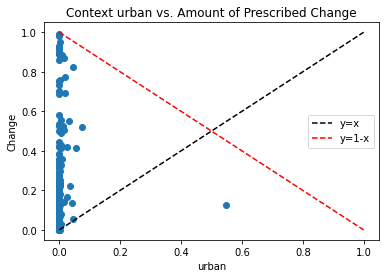

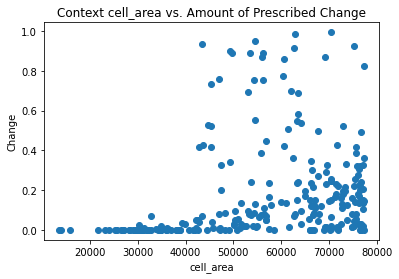

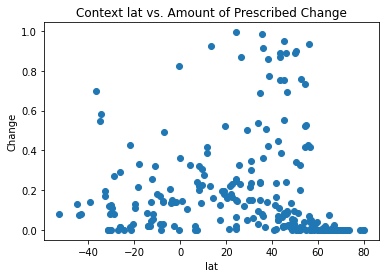

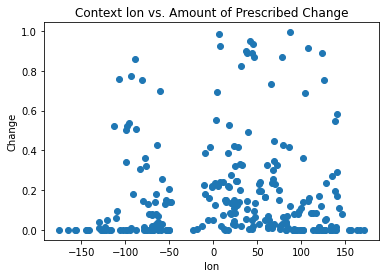

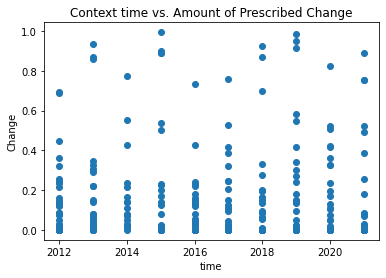

In [55]:
for feature in constants.LAND_USE_COLS + constants.NONLAND_FEATURES:
    plot_context_change(feature, False)

## Compare to Global Warming

In [36]:
pcts = [0.01, 0.05, 0.1, 0.2, 0.5, 1]
total_emissions = []
total_changes = []
for pct in pcts:
    result_df = heuristic_prescribe_and_predict(dataset.test_df.loc[2021][constants.CAO_MAPPING["context"]], dummy_prescriptor, perfect_prescribe, pct, linreg.coef_)
    result_df["total_emissions"] = result_df["ELUC"] * result_df["cell_area"]
    result_df["total_change"] = result_df["change"] * result_df["cell_area"]
    total_emissions.append(result_df["total_emissions"].sum())
    total_changes.append(result_df["total_change"].sum() / result_df["cell_area"].sum())

In [51]:
# Weight of CO2 vs. C
conversion = 3.664
# Remaining Carbon budget
rcb = 250
rcb2 = 1200
# Yearly net emissions
yearly = 20

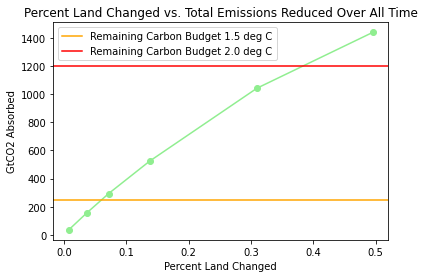

In [54]:
fig = plt.figure(facecolor="white")
plt.plot(total_changes, [-1 * t * conversion / 1e9 for t in total_emissions], marker="o", color="lightgreen")
plt.axhline(y=rcb, color='orange', label="Remaining Carbon Budget 1.5 deg C")
plt.axhline(y=rcb2, color='red', label="Remaining Carbon Budget 2.0 deg C")
plt.legend()
plt.title("Percent Land Changed vs. Total Emissions Reduced Over All Time")
plt.ylabel("GtCO2 Absorbed")
plt.xlabel("Percent Land Changed")
plt.show()

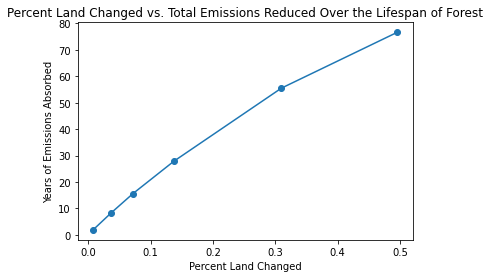

In [49]:
fig = plt.figure(facecolor="white")
plt.plot(total_changes, [t / (-18.78e9 / conversion) for t in total_emissions], marker="o")
plt.title("Percent Land Changed vs. Total Emissions Reduced Over the Lifespan of Forest")
plt.xlabel("Percent Land Changed")
plt.ylabel("Years of Emissions Absorbed")
plt.show()